# Remote PPG-Based Heart Rate Estimation from Binary ROI Signals

#### This notebook demonstrates a pipeline for estimating heart rate from precomputed binary signals representing average pixel intensities in specific facial regions (e.g., forehead or sclera). The workflow includes extracting a 1D signal from the video ROI, detrending and normalizing the signal, applying a bandpass filter to isolate cardiac frequency components, and computing the Welch power spectrum to identify the dominant frequency corresponding to heart rate.

###### All data used is non-identifiable: the binary files contain only numerical intensity values, without any reconstructable visual information or personal metadata. This setup allows experimental evaluation of remote photoplethysmography (rPPG) techniques while preserving privacy.

# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from scipy.signal import detrend as scipy_detrend
from scipy.signal import butter, filtfilt, welch

plt.rcParams['figure.figsize'] = (12, 4)


# Extracting Raw Green Signal from .bin File

### The green channel is commonly used in remote PPG analysis because hemoglobin absorbs green light more strongly than red or blue wavelengths. This makes the green channel more sensitive to blood volume changes in superficial vessels, resulting in a higher signal-to-noise ratio for detecting the cardiac pulse. While red and blue channels can also carry some pulsatile information, the green channel generally provides the clearest and most reliable waveform for heart rate estimation.

In [2]:
def load_bin_video(file_path, width=256, height=64, channels=3):
    """
    Loads a binary file representing a flattened RGB video tensor.
    Returns shape: (num_frames, height, width, channels)
    """
    file_path = Path(file_path)
    if not file_path.exists():
        raise FileNotFoundError(f"File not found: {file_path}")

    raw = np.fromfile(file_path, dtype=np.uint8)

    frame_size = width * height * channels
    num_frames = raw.size // frame_size

    raw = raw[: num_frames * frame_size]
    video = raw.reshape((num_frames, height, width, channels))

    return video

In [3]:
file_path = "Sclera\sclera-eye_left_all_256_64_1.bin" 
video = load_bin_video(file_path)
video.shape

(13564, 64, 256, 3)

In [4]:
def extract_raw_signal(video, channel=1):
    """
    Extract average pixel intensity over time.
    Default: Green channel.
    """
    return video[..., channel].mean(axis=(1, 2))


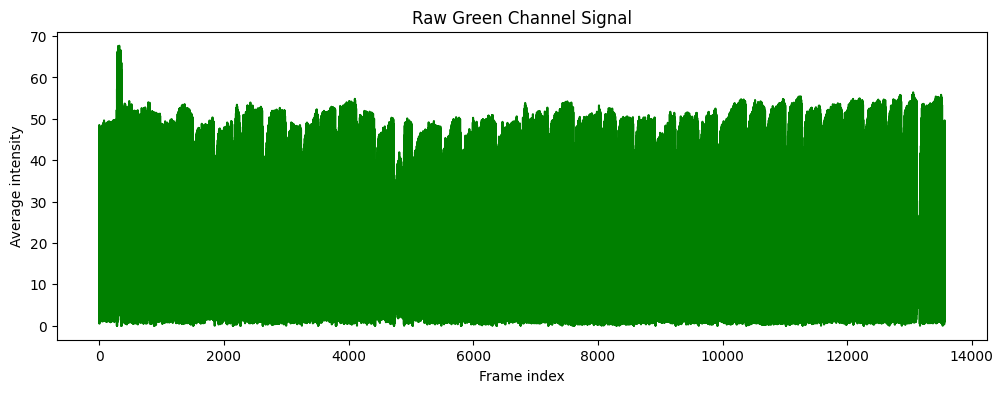

In [5]:
raw_signal = extract_raw_signal(video)
plt.plot(raw_signal, color='g')
plt.title("Raw Green Channel Signal")
plt.xlabel("Frame index")
plt.ylabel("Average intensity")
plt.show()

# Detrending & Normalization

### Detrending removes slow-varying changes or linear trends from the signal, such as baseline drift caused by lighting variations or subtle motion. Normalization then scales the signal to have zero mean and unit variance, which standardizes its amplitude and makes it easier to compare across different recordings or regions of interest. Together, detrending and normalization enhance the visibility of the underlying physiological variations, such as the heart-rate waveform, and improve the accuracy of subsequent filtering and frequency analysis.

In [6]:
def preprocess_signal(signal, do_detrend=True, do_normalize=True):
    """Applies detrending and normalization."""
    out = signal.astype(float)

    if do_detrend:
        out = scipy_detrend(out)

    if do_normalize:
        out = (out - np.mean(out)) / np.std(out)

    return out

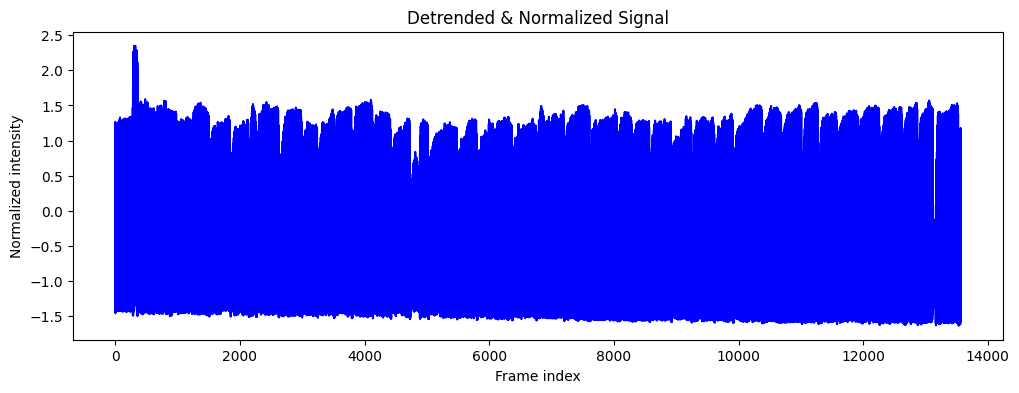

In [7]:
clean_signal = preprocess_signal(raw_signal)
plt.plot(clean_signal, color='blue')
plt.title("Detrended & Normalized Signal")
plt.xlabel("Frame index")
plt.ylabel("Normalized intensity")
plt.show()

# Band-pass Filter

### After applying the bandpass filter, the resulting signal primarily contains the frequency components associated with the heart rate. The filter removes baseline drift, motion artifacts, respiration-related fluctuations, and high-frequency noise, leaving a waveform that closely represents the underlying cardiac pulse. While it is not a perfectly “pure” heart-rate signal—some residual noise may still remain—it provides a much cleaner and more stable representation from which peak detection, heart rate, and HRV features can be reliably extracted.

In [8]:
def bandpass_filter(signal, fs, lowcut=0.7, highcut=4.0, order=4):
    nyq = fs / 2
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

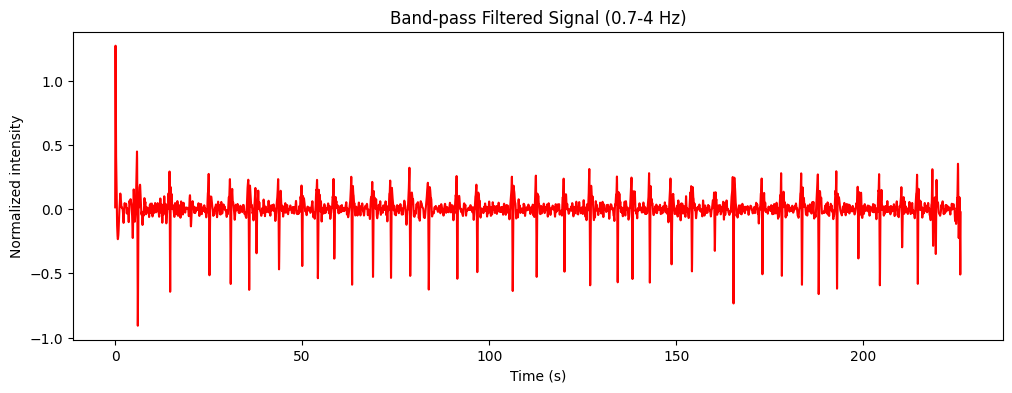

In [9]:
fs = 60  # FPS
filtered = bandpass_filter(clean_signal, fs)
time = np.arange(len(filtered)) / fs
plt.plot(time, filtered, color ="red")
plt.title("Band-pass Filtered Signal (0.7-4 Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized intensity")
plt.show()

# Finding the dominant frequency

### When computing the Welch power spectrum, we are estimating how the energy of the signal is distributed across different frequencies. Welch’s method splits the signal into overlapping segments, applies a window function to each segment to reduce spectral leakage, computes the periodogram of each segment, and then averages the results. This averaging process produces a smoother and more reliable power spectral density (PSD) estimate compared to a single FFT. By examining the PSD, we can identify the dominant frequency peak corresponding to the heart rate, while minimizing the impact of noise and temporal variability in the signal.

In [10]:
def estimate_bpm(signal, fs, fmin=0.7, fmax=4.0):
    f, Pxx = welch(signal, fs=fs, nperseg=1024)
    mask = (f >= fmin) & (f <= fmax)
    f_roi = f[mask]
    P_roi = Pxx[mask]

    dominant_freq = f_roi[np.argmax(P_roi)]
    bpm = dominant_freq * 60

    return bpm, dominant_freq, f_roi, P_roi

Dominant Frequency: 1.00 Hz
Estimated BPM: 59.8


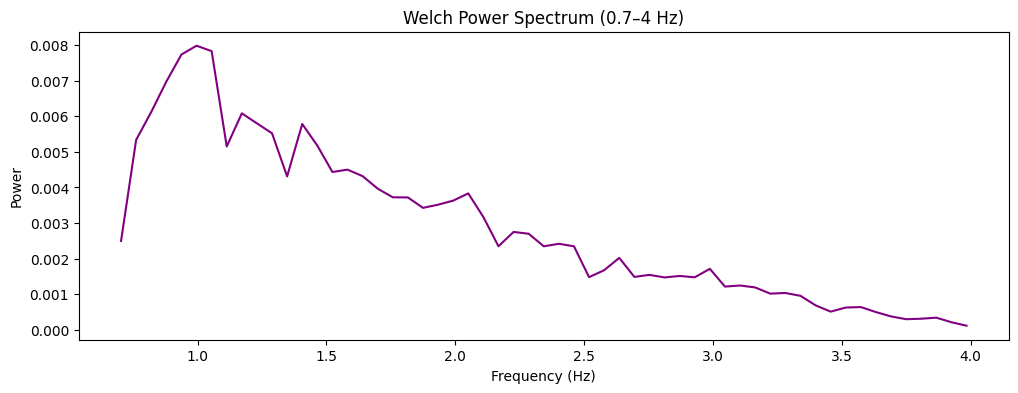

In [11]:
bpm, dom_f, f_roi, P_roi = estimate_bpm(filtered, fs)

print(f"Dominant Frequency: {dom_f:.2f} Hz")
print(f"Estimated BPM: {bpm:.1f}")

plt.plot(f_roi, P_roi, color='purple')
plt.title("Welch Power Spectrum (0.7–4 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.show()

## Full Pipeline (without the generation of signal graphs)

In [12]:
video = load_bin_video("Sclera\sclera-eye_left_all_256_64_1.bin")
raw = extract_raw_signal(video)
clean = preprocess_signal(raw)
filtered = bandpass_filter(clean, fs=60)
bpm, dom_f, f_roi, P_roi = estimate_bpm(filtered, fs=60)

print("Estimated BPM:", bpm)


Estimated BPM: 59.765625
